In [1]:
using Revise # Run this first, if you intend to develop the package

In [2]:
# unnecessary if you follow README
# using Pkg
# Pkg.activate("../QControl")
# Pkg.instantiate()

TODOs
- [ ] multiply by tanh rise and fall at beginning and end of pulse, 10ns
- [ ] look into why longer times are not working rn
- [ ] implement stricter amplitude constraint (maybe through parameterized pulse?)
- [ ] add population constraint
- [ ] figure out how to add linear constraints, if needed

# Imports

In [3]:
using QControl

In [4]:
const QC = QControl;

In [5]:
using QuantumOptics
using PyPlot
using Altro
using ForwardDiff
using LinearAlgebra
using SparseArrays
using RobotDynamics
using TrajectoryOptimization
using StaticArrays
using ForwardDiff
using FiniteDiff
const TO = TrajectoryOptimization
const RD = RobotDynamics
;

In [6]:
using PyCall;
# only needed once
# using Conda;
# Conda.add("qutip");
# Conda.add("imageio");

# Single Qubit System

In [27]:
bq_single = SpinBasis(1//2)
H₀_single = 2*π*.01*dm(e)
Hcs_single = [sigmax(bq_single)/2]
ψi_single = [spinup(bq_single)]
ψt_single = [-spinup(bq_single)]
;

In [28]:
# Base Dynamics
tf = 1.0 #ns
tspan = [0.0:0.01:tf;]
psi0 = normalize(spinup(bq_single)*.25 + spindown(bq_single)*.75)

# Dynamic function
function Ht(t,psi)
    return H₀_single
end

tout, psi_t = timeevolution.schroedinger_dynamic(tspan, psi0, Ht);

In [29]:
# animate_bloch(psi_t, duration=0.03, save_all=true)

# Set up Dynamics

In [30]:
RD.state_dim(::QC.QuantumState), RD.control_dim(::QC.QuantumState), dynamics_func, ψi_state, ψt_state = QC.gen_LQR_params(bq_single, H₀_single, Hcs_single, ψi_single, ψt_single)
RD.dynamics(qs::QC.QuantumState,x,u) = dynamics_func(qs::QC.QuantumState,x,u)
;

In [31]:
model = QC.QuantumState();

In [179]:
state_dim = RD.state_dim(model)
control_dim = RD.control_dim(model)

N = 1001 # number of time steps
tf = 20.0 # ns, total time
dt = tf / (N-1) # time step

obj = gen_default_objective(state_dim, control_dim, ψt_state; N=N, tf=tf, R_scale=0.0001)

Objective

In [165]:
# Add in normalization constraint and goal constraint
cons = ConstraintList(state_dim, control_dim, N)
normcon = NormConstraint(state_dim, control_dim, 1.0, Equality(), :state)
add_constraint!(cons, normcon, N)


# normcon = NormConstraint(state_dim, control_dim, π/3*2, Equality(), :control)
# add_constraint!(cons, normcon, N)

goalcon = GoalConstraint(ψt_state)
add_constraint!(cons, goalcon, N)

In [166]:
prob = Problem(model, obj, ψi_state, tf, xf=ψt_state, integration=RD.RK4(model), constraints=cons);

In [167]:
initial_controls!(prob, [@SVector rand(control_dim) for k = 1:N-1])
rollout!(prob)   # simulate the system forward in time with the new controls

In [168]:
# Set up solver options
opts = SolverOptions()
opts.cost_tolerance = 1e-8
opts.max_cost_value = 1e20

# Create a solver, adding in additional options
solver = ALTROSolver(prob, opts, show_summary=false);

In [ ]:
solve!(solver);

In [170]:
status(solver)

MAX_ITERATIONS_OUTER::TerminationStatus = 4

In [128]:
println("Number of iterations: ", iterations(solver))
println("Final cost: ", cost(solver))
println("Final constraint satisfaction: ", max_violation(solver)) #TODO: is 1 good??

Number of iterations: 113
Final cost: 0.7730918608426733
Final constraint satisfaction: 2.2199708737957735e-9


# Save Data

In [129]:
# save data (uncomment to save)
save_solver_data(solver, label=string("data_v2/pulse_", Integer(tf), "ns"))

In [180]:
# load data
data = load_solver_data(string("data_v2/pulse_", Integer(tf), "ns.jld2"))

Dict{String, Vector} with 2 entries:
  "U" => SVector{2, Float64}[[0.417331, 0.193195], [0.417575, 0.192665], [0.417…
  "X" => SVector{4, Float64}[[1.0, -1.26208e-19, 1.16789e-17, 8.67362e-19], [0.…

# Analysis

In [181]:
X = data["X"]    # alternatively states(prob)
U = data["U"]   # alternatively controls(prob)
Ucv = controls_to_amplitudes(U)
Urv = map(cv -> real(cv)[1], Ucv)
Uiv = map(cv -> imag(cv)[1], Ucv)
Uav = map(cv -> norm(cv)[1], Ucv)
Xqv = states_to_kets(X, bq_single)
;

In [182]:
println(Xqv[1])
println(Xqv[end])

Ket(dim=2)
  basis: Spin(1/2)
  1.0 + 1.0e-17im
 -0.0 + 0.0im
Ket(dim=2)
  basis: Spin(1/2)
          -1.0 - 2.238e-14im
 -1.895851e-11 + 3.12591e-11im


In [183]:
# szt = map(qv -> real(expect(sigmaz(bq_single),qv)), Xqv);
r1t = map(qv -> real(qv.data[1]), Xqv);
i1t = map(qv -> imag(qv.data[1]), Xqv);
leakaget = map(qv -> abs(qv.data[2]), Xqv);

# Plots

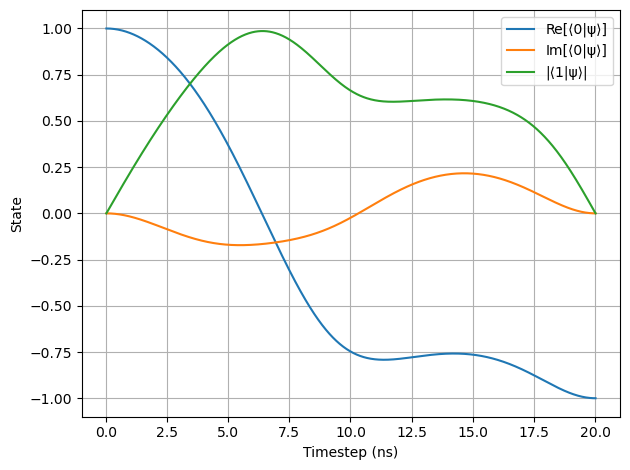

In [184]:
ts = 1:N
plot(dt*ts, r1t, label="Re[⟨0|ψ⟩]")
plot(dt*ts, i1t, label="Im[⟨0|ψ⟩]")
plot(dt*ts, leakaget, label="|⟨1|ψ⟩|")
xlabel("Timestep (ns)")
ylabel("State")
grid("on")
legend()
tight_layout()

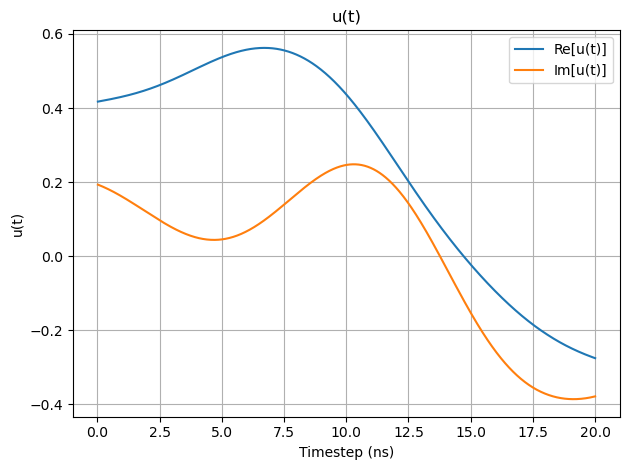

In [185]:
ts = 1:N-1
xlabel("Timestep (ns)")
ylabel("u(t)")
title("u(t)")
plot(dt*ts, Urv, label="Re[u(t)]")
plot(dt*ts, Uiv, label="Im[u(t)]")
# plot(dt*ts, Uav, label="|u(t)|")
grid("on")
legend()
tight_layout()

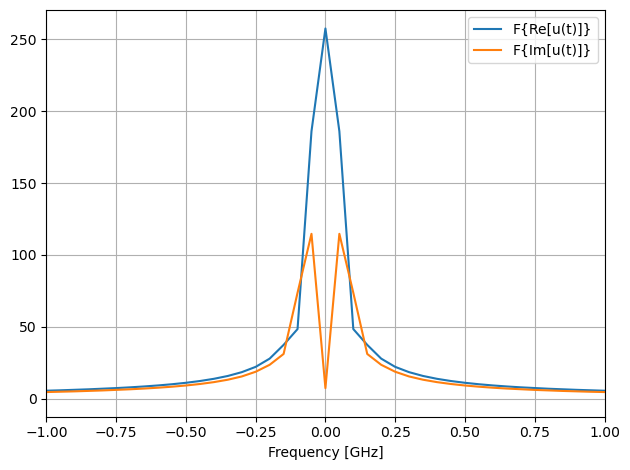

In [186]:
using FFTW
# using DSP

# Sample period
Ts = dt*N/(N-1)
# Start time 
t0 = 0 
tmax = tf
# time coordinate
t = t0:Ts:tmax


# real
signal = Urv
F_r = fft(signal) |> fftshift
freqs_r = fftfreq(length(t), 1.0/Ts) |> fftshift

# real
signal = Uiv
F_i = fft(signal) |> fftshift
freqs_i = fftfreq(length(t), 1.0/Ts) |> fftshift

# plots 
# time_domain = plot(t, signal)

freq_domain = plot(freqs_r, abs.(F_r), label="F{Re[u(t)]}")
freq_domain = plot(freqs_i, abs.(F_i), label="F{Im[u(t)]}")
xlabel("Frequency [GHz]")
xlim(-1,1)
grid("on")
legend()
tight_layout()

In [28]:
Xqv

1001-element Vector{Ket{SpinBasis{1//2, Int64}, Vector{ComplexF64}}}:
 Ket(dim=2)
  basis: Spin(1/2)
  1.0 - 3.0e-17im
 -0.0 - 0.0im
 Ket(dim=2)
  basis: Spin(1/2)
 0.999995770189119 - 0.00062807927175529im
 8.397202160572e-5 + 0.0028386738098053im
 Ket(dim=2)
  basis: Spin(1/2)
  0.9999830812852395 - 0.00125569671121324im
 0.00016437449055266 + 0.00567744221231837im
 Ket(dim=2)
  basis: Spin(1/2)
  0.9999619339567974 - 0.00188287735824361im
 0.00024120527053749 + 0.0085162920483374im
 Ket(dim=2)
  basis: Spin(1/2)
  0.9999323287057671 - 0.00250964626555707im
 0.00031446255045225 + 0.01135521016926617im
 Ket(dim=2)
  basis: Spin(1/2)
  0.9998942658674739 - 0.00313602849571235im
 0.00038414484433191 + 0.0141941834339905im
 Ket(dim=2)
  basis: Spin(1/2)
  0.9998477456104643 - 0.00376204911812289im
 0.00045025099128562 + 0.01703319870575259im
 Ket(dim=2)
  basis: Spin(1/2)
  0.9997927679364229 - 0.00438773320606606im
 0.00051278015541184 + 0.01987224284902396im
 Ket(dim=2)
  basis: Spin(1

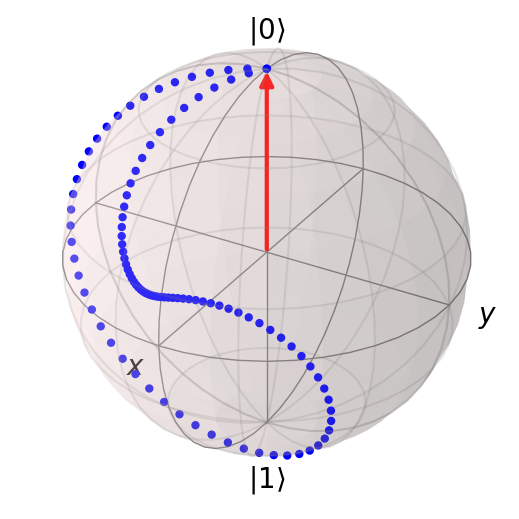

PyObject <qutip.bloch.Bloch object at 0x1d4c21310>

In [188]:
animate_bloch(Xqv[1:10:end], duration=0.03, save_all=true)

# References

[1] https://arxiv.org/pdf/1707.01060.pdf (quantum optics)

[2] https://github.com/alec-eickbusch/QOGS (quantum optimal gate synthesis)

[3] https://arxiv.org/pdf/2103.15716.pdf  (robotic quantum optimal control)

[4] https://journals.aps.org/prx/pdf/10.1103/PhysRevX.6.031006 (binomial code)